# 3D Geometric Model of Inflated Dunnage Bag - Reduction in Void

## Assumptions:

1. Material is rigid
2. Idealized geometry
3. Not rate dependent
4. Mass is constant
5. Temperature has no effect on the material or the inflated air

## Import Libraries:

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt, numpy as np
from scipy.interpolate import spline
from math import pi #import pi function for simple reference

## Functions:

In [2]:
#Find volume from length, width and diameter
def updateVolume(width,length,diameter):
    LengthLong = width - float(pi*diameter)/2 
    AreaLong = diameter*LengthLong + float(pi*diameter**2)/4
    LengthShort = length - float(pi*diameter)/2
    AreaShort = diameter*LengthShort + float(pi*diameter**2)/4
    VolumeSphere = float(1/6)*(diameter**3)*(pi)
    return (AreaLong*LengthShort) + (AreaShort*LengthLong) + VolumeSphere

In [3]:
#Update the Pressure using Ideal Gas Law
def updatePressure(mass,volume):
    return mass*8.3144598*298.15/volume

In [4]:
#Get the mass using the Ideal Gas Law (ABSOLUTE PRESSURE)
def updateMass(pressure,volume):
    return((101500-pressure) *volume)/(8.3144598*298.15)

In [5]:
#Get stess from Barlow's formula
def updateStress(diameter,pressure): 
    return (diameter*(pressure))/(2*1)

In [6]:
#Find the new length using the strain calculated
def updateLength(length,strain):
    ChangeInLength = length*strain 
    return length+ChangeInLength

In [7]:
#Get strain from stress-strain curve
def getStrain(stress,strain,stress_barlow):
    index = np.array(stress).searchsorted(stress_barlow)#find index from barlow's stress value
    x2 = strain[index-1] #find strain value to left
    x1 = strain[index] #find strain value to right
    y2 = stress[index-1] #find stress value to left
    y1 = stress[index] #find stress value to right
    return x1 + (stress_barlow-y1)*(x2 - x1)/(y2 - y1)

In [8]:
#Get new void size (new diameter), using Barlow Formula (RELATIV PRESSURE)
def updateDiameter(stress,pressure): 
    return 2*stress*1/(pressure)    

In [9]:
def addDiameter(d_red,d_change):
    return d_red - d_change

## Import Data for Stress-Strain:

In [10]:
#for root,dirs,files in os.walk('C:\Users\Inance\Documents\Thesis\Experiments\Tensile_Tests\Trial_Round\Tensile_test_mts\Inance_pp_mts\8_5_2016_300mm_min_GREEN\WAR'):
   # for file in files:
tensile=pd.read_csv(r'C:\Users\Inance\Documents\Thesis\Experiments\Tensile_Tests\Trial_Round\Tensile_test_mts\Inance_pp_mts\8_5_2016_300mm_min_GREEN\WARP\specimen1.1.txt',header=None,names=['Time','Load','Extension','Strain','Crosshead','Extensometer'])
load=np.array(tensile.Load)
crosshead=np.array(tensile.Crosshead)
sig=load*70*0.4*10**3
eps=((90-crosshead)/90)*10**-3
#print(sig,eps)

## Input Parameters - Main A:

In [11]:
#Constants:
w=0.9
d=0.5
l=[1.5] #initial length

#Initial values:

P=[20000]  #initial GAUGE pressure
V=[1]
m=[updateMass(P[0],V[0])] #initial mass from Ideal Gas Law
sig_b = [updateStress(d,P[0])] #initial stress form Barlows
epsa = [0.0]

#print ('sig =',sig,'\n','eps =',eps,)
print ('\n','P =',P,'\n','V =',V,'\n','m =',m,'\n','sig_b =',sig_b)

# Main A - loop parameters:
max_iter = 200 #maximum number of iterations
m_tol = 0.0005 #mass tolerance
i = 0 #starting number of iteration
m_diff = 10.0 #
m_old = 100 #old mass 


 P = [20000] 
 V = [1] 
 m = [32.87674076269672] 
 sig_b = [5000.0]


## Main A - Just Inflated:

In [12]:
print('P','\t','epsa','\t\t\t','l','\t\t','V','\t\t\t','m')#print variables names

while (m_diff >= m_tol and i < max_iter):
    P.append(P[0]) #update Pressure
    
    sig_b.append(updateStress(d,P[i+1])) #get Stress using Barlow's formula, GAUGE PRESSURE
    
    epsa.append(getStrain(sig,eps,sig_b[i+1])) #call Strain function
    
    l.append(updateLength(l[0],epsa[i+1]))#get updated length
    
    V.append(updateVolume(w,l[i+1],d)) #get Volume
    
    m.append(updateMass(P[i+1],V[i+1])) #initial mass from Ideal Gas Law, ABSOLUTE PRESSURE
    
    #Loop constraints
    m_diff = np.abs(m[i+1] - m_old) #calculate abs difference between old m and new m
    m_old = m[i+1] #set the old m equal to the current m for the next loop
    
    #print('m_diff =',m_diff)

    print (P[i+1],'\t',epsa[i+1],'\t',l[i+1],'\t',V[i+1],'\t',m[i+1])
    i+=1 #increment i to loop

P 	 epsa 			 l 		 V 			 m
20000 	 0.000856575618183 	 1.50128486343 	 0.310557820421 	 10.2101289538
20000 	 0.000856575618183 	 1.50128486343 	 0.310557820421 	 10.2101289538


## Input Parameters - Main B:

In [13]:
#Input parameters for Main B:
d_red=[0.3] #diameter with reduction main
m_red = [m[2]] #end mass of Main A, starting mass for Main B
V_red = [V[2]] #end volume of Main A, starting volume for Main B
P_red = [P[2]] #end pressure of Main A, starting pressure for Main B
sig_b_red = [sig_b[2]] #end barlow stress of Main A, starting barlow stress for Main B
epsa_red = [epsa[2]] #end strain of Main A, starting strain for Main B
l_red = [l[2]] #end length of Main A, starting length for Main B
d_change = [0.01] #change in diameter

#Loop parameters:
max_iter = 27
k = 0 #number of iterations
l_tol = 0.0005
l_diff = 10.0
l_old = 100

## Main B - Reduction in Void:

In [14]:
print('d_red','\t','P_red','\t\t\t','epsa_red','\t\t','V_red','\t\t','sig_b_red')

while l_diff >= l_tol and k < max_iter:
    
    V_red.append(updateVolume(w,l_red[k],d_red[0])) #get Volume
    
    P_red.append(updatePressure(m_red[0],V_red[k+1]))
    
    sig_b_red.append(updateStress(d_red[0],P_red[k+1]))
    
    epsa_red.append(getStrain(sig,eps,sig_b_red[k+1]))
    
    l_red.append(updateLength(l_red[0],epsa_red[k+1]))#get updated length
    
    #Loop constraints
    #l_diff = np.abs(l_red[k+1] - l_old) #calculate abs difference between old V and new V
    #l_old = l_red[k+1] #set the old V equal to the current V for the next loop
    print(d_red[0],'\t',P_red[k+1],'\t',epsa_red[k+1],'\t',V_red[k+1],'\t',sig_b_red[k+1])
    k+=1 #increment k to loop 

d_red 	 P_red 			 epsa_red 		 V_red 		 sig_b_red
0.3 	 66216.0928092 	 0.00080065568903 	 0.382240348086 	 9932.41392139
0.3 	 66147.8768518 	 0.000800784215871 	 0.382634538989 	 9922.18152778
0.3 	 66147.8659126 	 0.000800784236482 	 0.382634602267 	 9922.17988689
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3 	 66147.8659109 	 0.000800784236485 	 0.382634602277 	 9922.17988663
0.3

## MAIN - Time loop:

In [15]:
#for t in time:
    

## Input Graphs:

### Stress vs Strain

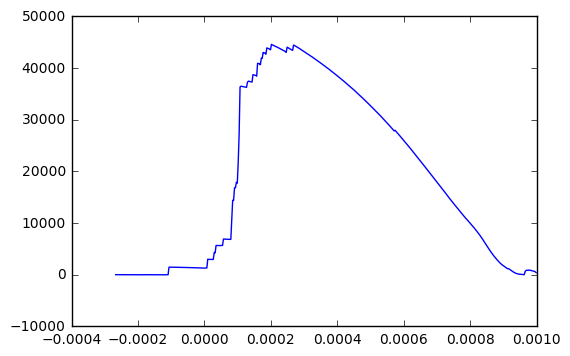

<function matplotlib.pyplot.close>

In [16]:
#Stress vs Strain - Data generated by Tensile Test

axis_font = {'fontname':'Constantia', 'size':'14'}
stress_strain=plt.show(plt.plot(eps,sig))
plt.ylabel("Stress",**axis_font),plt.xlabel("Strain",**axis_font)
plt.close

### Pressure vs Barlow's Stress

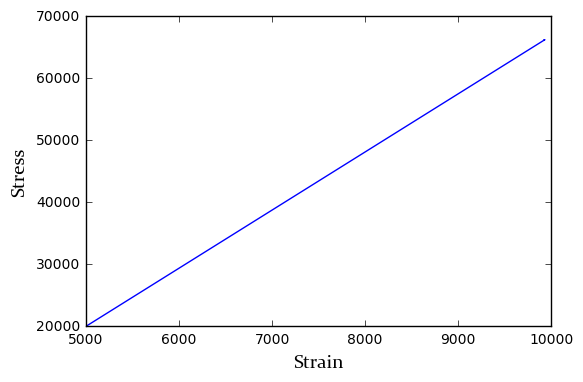

<function matplotlib.pyplot.close>

In [17]:
axis_font = {'fontname':'Constantia', 'size':'14'}
pressure_barlow=plt.show(plt.plot(sig_b_red,P_red))
plt.xlabel("Barlow's stress",**axis_font),plt.ylabel("Pressure",**axis_font)
plt.close

## Iteration Graphs:

### Pressure vs Iteration number

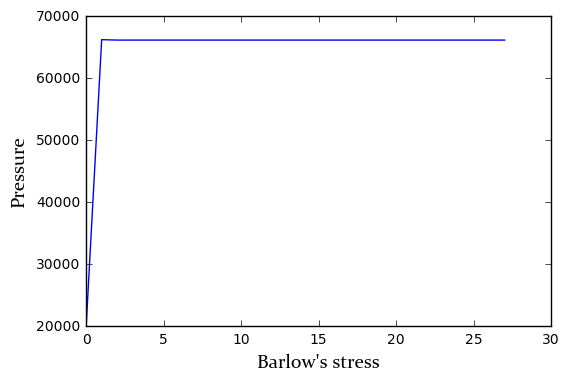

<function matplotlib.pyplot.close>

In [18]:
#Pressure vs Iteration number 
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(P_red)),P_red))
plt.ylabel("Pressure",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Diameter vs Iteration number

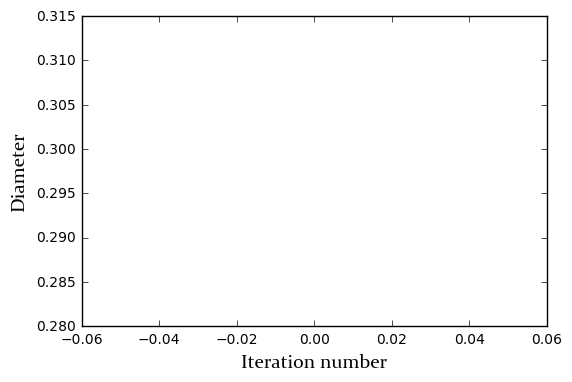

<function matplotlib.pyplot.close>

In [20]:
#Diameter vs Iteration number 
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(d_red)),d_red))
plt.ylabel("Diameter",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Strain vs Iteration number

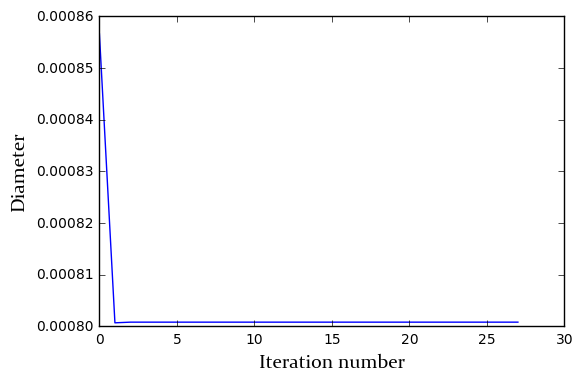

<function matplotlib.pyplot.close>

In [21]:
#Strain vs Iteration number 
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(epsa_red)),epsa_red))
plt.ylabel("Calculated Strain",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Volume vs Iteration number

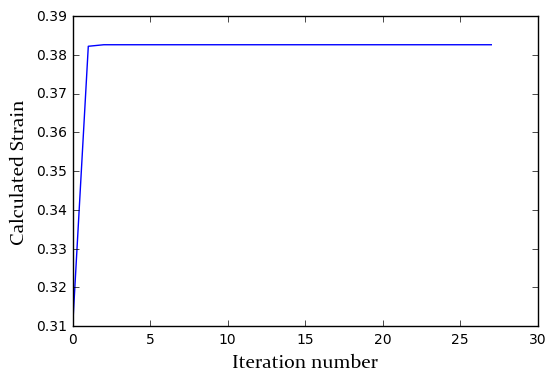

<function matplotlib.pyplot.close>

In [22]:
#Volume vs Iteration number 
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(V_red)),V_red))
plt.ylabel("Volume",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close

### Barlow's Stress vs Iteration number

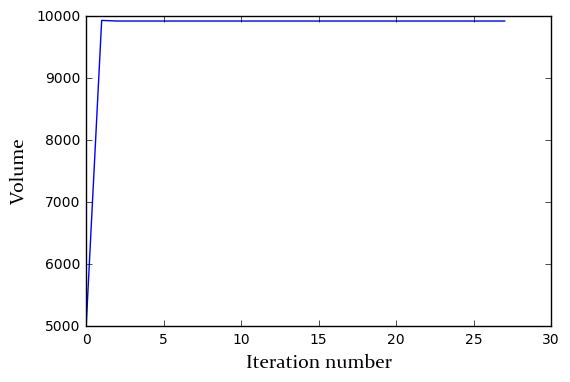

<function matplotlib.pyplot.close>

In [23]:
#Barlow's Stress vs Iteration number 
axis_font = {'fontname':'Constantia', 'size':'14'}
plt.show(plt.plot(range(len(sig_b_red)),sig_b_red))
plt.ylabel("Barlow's Stress",**axis_font),plt.xlabel("Iteration number",**axis_font)
plt.close